
<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/NCAR-contemp-logo-blue.png"
     width="750px"
     alt="NCAR logo"
     style="vertical-align:middle;margin:30px 0px"/>

# Introduction to Xarray
**ESDS 2024 Annual Event Xarray-Dask Tutorial | January 19th, 2023**  

Negin Sobhani, Brian Vanderwende, and Ben Kirk  
Computational & Information Systems Lab (CISL)  
[negins@ucar.edu](mailto:negins@ucar.edu), [vanderwb@ucar.edu](mailto:vanderwb@ucar.edu)

------

### In this tutorial, you learn:

* Understand the basic data structures in Xarray
* Inspect `DataArray` and `Dataset` objects.
* Read and write netCDF files using Xarray.
* Understand that there are many packages that build on top of xarray


### Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| Basic familiarity with NumPy	 | Necessary | |
| Basic familiarity with Pandas	 | Necessary | |

- **Time to learn**: 40 minutes
---------

## Introduction

### What is Xarray?
     
Xarray is an open-source Python library designed for working with *labelled multi-dimensional* data. By *multi-dimensional* data (also often called *N-dimensional*), we mean data that has many independent dimensions or axes (e.g. latitude, longitude, time). By labelled we mean that these axes or dimensions are associated with coordinate names (like "latitude") and coordinate labels like "30 degrees North".

Xarray provides pandas-level convenience for working with this type of data.


<img src="https://docs.xarray.dev/en/stable/_images/dataset-diagram.png"
     width="50%"
     alt="Xarray"
     style="vertical-align:middle;margin:30px 0px"/>

*Image credit: Xarray Contributors*

The dataset illustrated has two variables (`temperature` and `precipitation`) that have three dimensions. Coordinate vectors (e.g., latitude, longitude, time) that describe the data are also included.

     
### Xarray Fundamental Data Structures

Xarray has two fundamental data structures:

* `DataArray` : holds a single multi-dimensional variable and its coordinates
* `Dataset` : holds multiple DataArrays that potentially share the same coordinates


**Xarray DataArray**

A `DataArray` has four essential attributes:
* `data`: a `numpy.ndarray` holding the values.
* `dims`: dimension names for each axis (e.g., latitude, longitude, time).
* `coords`: a dict-like container of arrays (coordinates) that label each point (e.g., 1-dimensional arrays of numbers, datetime objects or strings).
* `attrs`: a dictionary to hold arbitrary metadata (attributes).

**Xarray DataSet**

A dataset is simply an object containing multiple Xarray DataArrays indexed by variable name.

## Reading and Writing Data with Xarray

One of Xarray's most widely used features is its ability to [read from and write
to a variety of data formats](https://docs.xarray.dev/en/stable/user-guide/io.html). 
For example, Xarray can read the following formats using `open_dataset`/`open_mfdataset`:

- [NetCDF](https://www.unidata.ucar.edu/software/netcdf/)
- [Zarr](https://zarr.readthedocs.io/en/stable/)

Support for additional formats is possible using external packages
- [GRIB](https://en.wikipedia.org/wiki/GRIB) using the [cfgrib](https://github.com/ecmwf/cfgrib) package
- [GeoTIFF](https://gdal.org/drivers/raster/gtiff.html) /
  [GDAL rasters](https://svn.osgeo.org/gdal/tags/gdal_1_2_5/frmts/formats_list.html)
  using the [rioxarray package](https://corteva.github.io/rioxarray/stable/)

<img src="https://www.unidata.ucar.edu/images/logos/netcdf-400x400.png" align="right" width="20%">

## NetCDF

The recommended way to store xarray data structures is NetCDF, which is a binary
file format for self-described datasets that originated in the geosciences.
Xarray is based on the netCDF data model, so netCDF files on disk directly
correspond to Dataset objects.

Xarray reads and writes to NetCDF files using the `open_dataset` /
`open_dataarray` functions and the `to_netcdf` method.

Let's first create some datasets and write them to disk using `to_netcdf`, which
takes the path we want to write to:


In [10]:
import numpy as np
import xarray as xr

# Ensure random arrays are the same each time
np.random.seed(0)

The constructor of `Dataset` takes three parameters:

- `data_vars`: dict-like mapping names to values. Values are either `DataArray` objects
  or defined with tuples consisting of of dimension names and arrays.
- `coords`: same as for `DataArray`
- `attrs`: same as for `DataArray`

In [11]:
ds1 = xr.Dataset(
    data_vars={
        "a": (("x", "y"), np.random.randn(4, 2)),
        "b": (("z", "x"), np.random.randn(6, 4)),
    },
    coords={
        "x": np.arange(4),
        "y": np.arange(-2, 0),
        "z": np.arange(-3, 3),
    },
)
ds2 = xr.Dataset(
    data_vars={
        "a": (("x", "y"), np.random.randn(7, 3)),
        "b": (("z", "x"), np.random.randn(2, 7)),
    },
    coords={
        "x": np.arange(6, 13),
        "y": np.arange(3),
        "z": np.arange(3, 5),
    },
)

# write datasets
ds1.to_netcdf("ds1.nc")
ds2.to_netcdf("ds2.nc")

# write dataarray
ds1.a.to_netcdf("da1.nc")

PermissionError: [Errno 13] Permission denied: '/glade/work/negins/ESDS-2024-Xarray-Dask/notebooks/ds1.nc'

Reading those files is just as simple:

In [12]:
xr.open_dataset("ds1.nc")

<xarray.Dataset>
Dimensions:  (x: 4, y: 2, z: 6)
Coordinates:
  * x        (x) int64 0 1 2 3
  * y        (y) int64 -2 -1
  * z        (z) int64 -3 -2 -1 0 1 2
Data variables:
    a        (x, y) float64 ...
    b        (z, x) float64 ...

In [13]:
xr.open_dataarray("da1.nc")

<xarray.DataArray 'a' (x: 4, y: 2)>
[8 values with dtype=float64]
Coordinates:
  * x        (x) int64 0 1 2 3
  * y        (y) int64 -2 -1

### Xarray can wrap many array types like Numpy and Dask.

Let's start with a random 2D NumPy array, for example this can be SST (sea-surface temperature) values of a domain with dimension of 300x450 grid:

In [14]:
import numpy as np 
import dask.array as da
import xarray as xr

xr.set_options(display_expand_data=False);

In [15]:
# -- numpy array 
sst_np = np.random.rand(300,450)
type(sst_np)

numpy.ndarray

As we saw in the previous tutorial, we can convert them to a Dask Array:

In [16]:
sst_da = da.from_array( sst_np)
sst_da

dask.array<array, shape=(300, 450), dtype=float64, chunksize=(300, 450), chunktype=numpy.ndarray>

This is great and fast! BUT
* What if we want to attach coordinate values to this array?
* What if we want to add metadata (e.g. units) to this array?

In [17]:
# similarly we can convert them to xarray datarray
sst_xr = xr.DataArray(sst_da)
sst_xr

<xarray.DataArray 'array-6b85fe1911faa1be3ee641f28a40c188' (dim_0: 300,
                                                            dim_1: 450)>
dask.array<chunksize=(300, 450), meta=np.ndarray>
Dimensions without coordinates: dim_0, dim_1

A simple DataArray without dimensions or coordinates isn't much use.

In [18]:
# we can add dimension names to this:
sst_xr = xr.DataArray(sst_da,dims=['lat','lon'])

sst_xr.dims

('lat', 'lon')

We can add our coordinates with values to it :


In [19]:
# -- create some dummy values for lat and lon dimensions
lat = np.random.uniform(low=-90, high=90, size=300)
lon = np.random.uniform(low=-180, high=180, size=450)

sst_xr = xr.DataArray(sst_da,
                      dims=['lat','lon'],
                      coords={'lat': lat, 'lon':lon},
                      attrs=dict(
                        description="Sea Surface Temperature.",
                        units="degC")
                     )
sst_xr

<xarray.DataArray 'array-6b85fe1911faa1be3ee641f28a40c188' (lat: 300, lon: 450)>
dask.array<chunksize=(300, 450), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 -83.23 -41.56 -83.73 8.266 ... -27.92 13.18 16.39
  * lon      (lon) float64 157.6 105.2 -111.8 -9.475 ... -100.5 95.35 -83.28
Attributes:
    description:  Sea Surface Temperature.
    units:        degC

Xarray data structures are a very powerful tool that allows us to use metadata to express different analysis patterns (slicing, selecting, groupby, averaging, and many other things). 

<div class="alert alert-success fade show" markdown="1">

<b>Take Away</b> 

Xarray DataArray provides a wrapper around arrays, and uses labeled dimensions and coordinates to support metadata-aware operations (e.g. `da.sum(dim="time")` instead of `array.sum(axis=-1)`)

**Xarray can wrap dask arrays instead of numpy arrays.** 

This capability turns Xarray into an extremely useful tool for Big Data earth science.
</div>

With this introduction, let's start our tutorial on features of Xarray and Dask:

### Setup: Spinning up a cluster

In [20]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/8787/status,Workers: 1
Total threads: 1,Total memory: 4.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37487,Workers: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/8787/status,Total threads: 1
Started: Just now,Total memory: 4.00 GiB
Comm: tcp://127.0.0.1:39665,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/34131/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:36965,


-----------
## Reading data with Dask and Xarray

### Reading multiple netCDF files with `open_mfdataset`

Xarray provides a function called `open_dataset` function that allows us to load a netCDF dataset into a Python data structure. To read more about this function, please see [xarray `open_dataset` API documentation](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html). 

Xarray also provides `open_mfdataset`, which open multiple files as a single xarray dataset. Passing the argument `parallel=True` will speed up reading multiple datasets by executing these tasks in parallel using Dask Delayed under the hood. 

In this example, we are going to examine a subset  of CESM2 Large Ensemble Data Sets (LENS). We will use 2m temperature (TREFHT) for this analysis. 

To learn more about LENS dataset, please visit:
* [LENS official website](https://www.cesm.ucar.edu/community-projects/lens/data-sets)
* [LENS paper](https://www.cesm.ucar.edu/community-projects/lens/data-sets)

For this tutorial, we only look at a small subset of data. If you don't have the data, running the following code enables you to download, prepare, and stage the required datasets (`../data/` folder) for this cookbook.

In [29]:
!./get_data.sh notebook3

data_for_cesm/
data_for_cesm/b.e21.BSSP370smbb.f09_g17.LE2-1301.013.cam.h0.TREFHT.205501-206412.nc
data_for_cesm/b.e21.BSSP370smbb.f09_g17.LE2-1301.013.cam.h0.TREFHT.209501-210012.nc
data_for_cesm/b.e21.BSSP370smbb.f09_g17.LE2-1301.013.cam.h0.TREFHT.202501-203412.nc
data_for_cesm/b.e21.BSSP370smbb.f09_g17.LE2-1301.013.cam.h0.TREFHT.204501-205412.nc
data_for_cesm/b.e21.BSSP370smbb.f09_g17.LE2-1301.013.cam.h0.TREFHT.207501-208412.nc
data_for_cesm/b.e21.BSSP370smbb.f09_g17.LE2-1301.013.cam.h0.TREFHT.201501-202412.nc
data_for_cesm/b.e21.BSSP370smbb.f09_g17.LE2-1301.013.cam.h0.TREFHT.206501-207412.nc
data_for_cesm/b.e21.BSSP370smbb.f09_g17.LE2-1301.013.cam.h0.TREFHT.203501-204412.nc
data_for_cesm/b.e21.BSSP370smbb.f09_g17.LE2-1301.013.cam.h0.TREFHT.208501-209412.nc


We can open up multiple files using `open_mfdataset` function. 

### Constructing Xarray Datasets from files

In [31]:
import os
import glob

var = 'TREFHT'

# find all LENS files for 1 ensemble
data_dir = '../data/data_for_cesm'
files = glob.glob(os.path.join(data_dir, 'b.e21.BSSP370smbb.f09_g17.LE2-1301.013*.nc'))

print("All files: [", len(files), "files]")

All files: [ 9 files]


In [32]:
%%time
ds = xr.open_mfdataset(
    sorted(files),
    # concatenate along this dimension
    concat_dim="time",
    # concatenate files in the order provided
    combine="nested",
    # parallelize the reading of individual files using dask
    # This means the returned arrays will be dask arrays
    parallel=True,
    # these are netCDF4 files, use the h5netcdf package to read them
    engine="h5netcdf",
    # hold off on decoding time
    decode_cf=False,
    # specify that data should be automatically chunked
    chunks="auto",
)
ds = xr.decode_cf(ds)
ds

CPU times: user 262 ms, sys: 52.2 ms, total: 314 ms
Wall time: 4.64 s


<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, time: 1032, nbnd: 2, lon: 288, lev: 32,
                   ilev: 33)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/27)
    zlon_bnds     (time, zlon, nbnd) float64 dask.array<chunksize=(120, 1, 2), meta=np.ndarray>
    gw            (time, lat) float64 dask.array<chunksize=(120, 192), meta=np.ndarray>
    hyam          (time, lev) float64 dask.array<chunksize=(120, 32), meta=np.ndarray>
    hybm          (time, lev) float64 dask.array<chunksize=(120, 32), meta=np.ndarray>
    P0            (time) float64 ...
    hyai          (time, ilev) float64 dask.array<chunksize=(120, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(120,), meta=np.ndarray>
    TREFHT        (time, lat, lon) float32 dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSSP370smbb.f09_g17.LE2-1301.013
    logname:           sunseon
    host:              mom1
    initial_file:      b.e21.BHISTsmbb.f09_g17.LE2-1301.013.cam.i.2015-01-01-...
    topography_file:   /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/fv_0.9x...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

For complex scenarios, you can access each file individually by utilizing the `open_dataset` function with the specified `chunk`s and then combine the outputs into a single dataset later.

Note that the "real" values are not displayed, since that would trigger actual computation.  
<div class="alert alert-success" markdown="1">

Xarray automatically wraps Dask Arrays and Dask is lazy, meaning that operations are not computed until we explicitly request them, for example by calling `.compute()`.

</div>


Please see previous notebooks for more information on "lazy evaluation". 

The represntation of `TREFHT` DataArray shows details of chunks and chunk-sizes of Xarray DataArray:

In [33]:
tref = ds.TREFHT
tref

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

In [34]:
tref.chunks

((120, 120, 120, 120, 120, 120, 120, 120, 72), (192,), (288,))

* How many chunks do we have? 
* What is the size of each chunk size?

Here we can see that we have a total of 9 chunks - equal to the number of our netCDF files. In general `open_mfdataset` will return one chunk per netCDF file.

<div class="alert alert-block alert-warning">

**WARNING:** The chunk structure within the file is important. When re-chunking the dataset after creation with `ds.chunk()` it is recommended to only use multiples of the on-file chunk shape.

</div>

We can check what that shape is by looking at the encoding:

In [35]:
tref.encoding

{'chunksizes': (1, 192, 288),
 'fletcher32': False,
 'shuffle': True,
 'zlib': True,
 'complevel': 1,
 'source': '/glade/work/negins/ESDS-2024-Xarray-Dask/data/data_for_cesm/b.e21.BSSP370smbb.f09_g17.LE2-1301.013.cam.h0.TREFHT.201501-202412.nc',
 'original_shape': (120, 192, 288),
 'dtype': dtype('float32')}

<div class="alert alert-block alert-info" markdown="1">

**TIP:** The `chunks` parameter can significantly affect total performance when using Dask Arrays. `chunks` should be small enough that each chunk fit in the memory, but large enough to avoid that the communication overhead. 

</div>

A good rule of thumb is to create arrays with a minimum chunksize of at least one million elements. Here we have 120x192x288 elements in each chunk (except for the last chunk).   
With large arrays (10+ GB), the cost of queuing up Dask operations can be noticeable, and you may need even larger chunksizes. 

**Additional Reading**

 - [dask.array best practices](https://docs.dask.org/en/stable/array-best-practices.html#select-a-good-chunk-size)
 - [NCAR chunking tutorial](https://ncar.github.io/dask-tutorial/notebooks/06-dask-chunking.html)
 - [Dask blog post on chunking](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes)

### Xarray data structures are Dask collections.

This means you can call the following Dask-related functions on Xarray Data Arrays and Datasets:

* `.visualize()`
* `.compute()`
* `.persist()`

For more information about Dask Arrays, please see [Dask Array chapter](https://projectpythia.org/dask-cookbook/notebooks/01-dask-array.html).

In [36]:
tref_mean = tref.mean('time')
tref_mean.data.dask

HighLevelGraph with 22 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x14f384530be0>
 0. original-open_dataset-TREFHT-829692327d0c603dfb15dca2e3dcdc44
 1. open_dataset-TREFHT-829692327d0c603dfb15dca2e3dcdc44
 2. original-open_dataset-TREFHT-f86d7279a6eb1e8b525fd433a35f8212
 3. open_dataset-TREFHT-f86d7279a6eb1e8b525fd433a35f8212
 4. original-open_dataset-TREFHT-5dc9996db723cb182026c4f1703afbb0
 5. open_dataset-TREFHT-5dc9996db723cb182026c4f1703afbb0
 6. original-open_dataset-TREFHT-1bec5697677600ec285823b8894b0aef
 7. open_dataset-TREFHT-1bec5697677600ec285823b8894b0aef
 8. original-open_dataset-TREFHT-b376d457af800028faa60fbb881274e7
 9. open_dataset-TREFHT-b376d457af800028faa60fbb881274e7
 10. original-open_dataset-TREFHT-490e30721b157769a0556664ad692090
 11. open_dataset-TREFHT-490e30721b157769a0556664ad692090
 12. original-open_dataset-TREFHT-971435323705299ff3d752a5ef032e55
 13. open_dataset-TREFHT-971435323705299ff3d752a5ef032e55
 14. original-open_dataset-TREFHT-b78db7e389278ff8df22805186deb05f
 15. open_dataset-TREFHT-b78db7e389278ff8df22805186deb05f
 16. original-open_dataset-TREFHT-f5a6416afc1782a1e95d5966b17d38c7
 17. open_dataset-TREFHT-f5a6416afc1782a1e95d5966b17d38c7
 18. concatenate-a6c5fea69b791b9738ccc6ae9cc7b754
 19. mean_chunk-ea9b6860fd613ff87e2d51c4fd9ddad3
 20. mean_combine-partial-29ebc4186cd8978740b8f6d09e980557
 21. mean_agg-aggregate-1b12ee8daaf71a9d05ebb4f0b5aeb961

If we check Dask Task Graph for `tref_mean`, we can see all the steps required for calculating it (from opening the netcdf file to calculating mean and aggreagting it). 

### Getting concrete values
At some point, you will want to actually do the calculations and receive concrete values from Dask.

There are two ways to compute values on dask arrays.

  1. `compute()` returns a new xarray object with the data now represented as a numpy array.
  2. `load()` replaces the dask array in the xarray object with a numpy array. Equivalent to `ds = ds.compute()`.

`.load()` operates *inplace* and `.compute()` returns a new xarray object.

#### Distributed non-blocking concrete values

There is another option available  third option : “persisting”. `.persist()` loads the values into distributed RAM. The values are computed but remain distributed across workers. So essentially `persist` turns a lazy Dask collection into a Dask collection where the results are either fully computed or actively computing in the background.

So `ds.air.persist()` is still backed by a Dask array. This is useful if you will be repeatedly using a dataset for computation but it is too large to load into local memory. 

Read more: [Dask user guide](https://docs.dask.org/en/stable/generated/dask.dataframe.Series.persist.html)


## How to access underlying data in an Xarray object?

There are two basic ways to extract values from an Xarray object:

1. Using `.data` will return a Dask array. For example:

In [37]:
tref.data

dask.array<concatenate, shape=(1032, 192, 288), dtype=float32, chunksize=(120, 192, 288), chunktype=numpy.ndarray>

**This means that for Dask-backed Xarray object, we can access the values using `.compute`**

In [38]:
%%time

tref.data.compute()

CPU times: user 123 ms, sys: 157 ms, total: 280 ms
Wall time: 1.42 s


array([[[248.39987, 248.39989, 248.39992, ..., 248.39989, 248.39989,
         248.39989],
        [248.95004, 248.9094 , 248.75017, ..., 248.98384, 248.97466,
         248.9626 ],
        [249.20784, 249.17082, 249.15718, ..., 249.42188, 249.37703,
         249.31105],
        ...,
        [251.5821 , 251.6182 , 251.65166, ..., 251.48357, 251.51555,
         251.54646],
        [251.34143, 251.35114, 251.36166, ..., 251.30699, 251.32008,
         251.3312 ],
        [251.35237, 251.35286, 251.35332, ..., 251.35059, 251.35123,
         251.35182]],

       [[237.44759, 237.44759, 237.44759, ..., 237.44759, 237.44759,
         237.44759],
        [238.10292, 238.05934, 237.8917 , ..., 238.16042, 238.14326,
         238.12119],
        [238.86865, 238.82155, 238.79092, ..., 239.1196 , 239.04976,
         238.96754],
        ...,
        [246.23404, 246.25865, 246.28221, ..., 246.15912, 246.18312,
         246.20715],
        [246.70511, 246.7112 , 246.71793, ..., 246.68782, 246.69476,
   

2. We can also use `.values` to see the "real" values of Xarray object. Another option is using `.to_numpy`. Both of these option return the values of underlying Dask object in a numpy array. 

In [39]:
%%time
tref.to_numpy()

CPU times: user 109 ms, sys: 174 ms, total: 284 ms
Wall time: 1.42 s


array([[[248.39987, 248.39989, 248.39992, ..., 248.39989, 248.39989,
         248.39989],
        [248.95004, 248.9094 , 248.75017, ..., 248.98384, 248.97466,
         248.9626 ],
        [249.20784, 249.17082, 249.15718, ..., 249.42188, 249.37703,
         249.31105],
        ...,
        [251.5821 , 251.6182 , 251.65166, ..., 251.48357, 251.51555,
         251.54646],
        [251.34143, 251.35114, 251.36166, ..., 251.30699, 251.32008,
         251.3312 ],
        [251.35237, 251.35286, 251.35332, ..., 251.35059, 251.35123,
         251.35182]],

       [[237.44759, 237.44759, 237.44759, ..., 237.44759, 237.44759,
         237.44759],
        [238.10292, 238.05934, 237.8917 , ..., 238.16042, 238.14326,
         238.12119],
        [238.86865, 238.82155, 238.79092, ..., 239.1196 , 239.04976,
         238.96754],
        ...,
        [246.23404, 246.25865, 246.28221, ..., 246.15912, 246.18312,
         246.20715],
        [246.70511, 246.7112 , 246.71793, ..., 246.68782, 246.69476,
   

## Computation

All built-in Xarray methods (`.mean`, `.max`, `.rolling`, `.groupby` etc.) support dask arrays.

Now, let's do some computations on this Xarray dataset. 

### Single Point Calculations

To start out, let's do the calculations on a single point first. First, we extract the time series data at a grid point and save it to a variable. Here we select the closest point using `.sel` and load the data. 

In [40]:
tref_boulder = tref.sel(lat=40.0150, lon=-105.2705, method='nearest').load()

<div class="alert alert-block alert-warning" markdown="1">

**WARNING:** Remember as soon as you call `.load()` you are telling Dask to trigger computation.

</div>

In [41]:
# -- take annual average
tb = tref_boulder.resample(time='AS').mean()
tb

<xarray.DataArray 'TREFHT' (time: 87)>
291.8 290.3 290.3 290.1 290.7 291.2 ... 294.3 293.5 293.5 293.4 293.9 289.8
Coordinates:
    lat      float64 40.05
    lon      float64 0.0
  * time     (time) object 2015-01-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

We can either see the values of our DataArray in the text representation above or by plotting it:

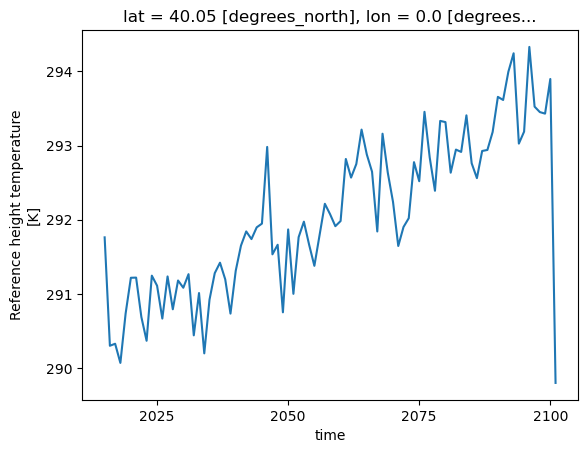

In [42]:
tb.plot()

### Calculations over all grids

In [43]:
# change the unit from Kelvin to degree Celsius 
tref_c = tref - 273.15
tref_c

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00

In [44]:
%%time 

tref_c = tref_c.load()

CPU times: user 126 ms, sys: 168 ms, total: 294 ms
Wall time: 1.52 s


In [45]:
%%time

# Compute monthly anomaly

# -- 1. calculate monthly average
tref_grouped = tref.groupby('time.month')
tmean = tref_grouped.mean(dim='time')

#-- 2. calculate monthly anomaly
tos_anom = tref_grouped - tmean
tos_anom

CPU times: user 16.9 ms, sys: 122 µs, total: 17.1 ms
Wall time: 17.3 ms


<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [ ]:
%%time
computed_anom = tos_anom.load()
type(computed_anom)

In [ ]:
tos_anom.sel(lon=310, lat=50, method='nearest').plot( size=4)

In [ ]:
tos_anom.sel(time='2030-01-01').plot()

<div class="alert alert-block alert-info" markdown="1">

<b>TIP:</b> Using Xarray plotting functionality automatically triggers computations on the Dask Array, similar to `.compute()`.

</div>

We can do more complex calculations too:

In [ ]:
rolling_mean = tref.rolling(time=5).mean()
rolling_mean  # contains dask array

In [ ]:
timeseries = rolling_mean.isel(lon=1, lat=20)  # no activity on dashboard
timeseries  # contains dask array

In [ ]:
computed = rolling_mean.compute()  # activity on dashboard
computed  # has real numpy values

### Supplementary Material: Advanced workflows and automatic parallelization using `apply_ufunc`
Most of xarray’s built-in operations work on Dask arrays. If you want to use a function that isn’t wrapped by Xarray to work with Dask, one option is to extract Dask arrays from xarray objects (.data) and use Dask directly.

Another option is to use xarray’s `apply_ufunc()` function. `xr.apply_ufunc()` can automate embarrassingly parallel “map” type operations where a function written for processing NumPy arrays, but we want to apply it on our Xarray DataArray. 

`xr.apply_ufunc()` give users capability to run custom-written functions such as parameter calculations in a parallel way. See the [Xarray tutorial material on apply_ufunc](https://tutorial.xarray.dev/advanced/apply_ufunc/apply_ufunc.html) for more.

In the example below, we calculate the saturation vapor pressure by using `apply_ufunc()` to apply this function to our Dask Array chunk by chunk. 

In [ ]:
import numpy as np

def sat_p(t):
    """Calculate saturation vapor pressure using Clausius-Clapeyron equation"""
    return 0.611 * np.exp(17.67 * (t-273.15)*((t-29.65)**(-1)))

In [ ]:
es = xr.apply_ufunc(sat_p, tref, dask="parallelized", output_dtypes=[float])
es

In [ ]:
es.compute()

The data used for this tutorial is from one ensemble member. What if we want to use multiple ensemble members? So far, we only run on one machine, what if we run an HPC cluster? We will go over this in the next tutorial.

### Dask + Xarray Good Practices

<div class="alert alert-success fade show" markdown="1">

<b>Summary of Dask + Xarray Good Practices</b> 


The good practices regarding Dask + Xarray is the same as the good practices for Dask only.

* Similar to Dask DataFrames, it is more efficient to first do spatial and temporal indexing (e.g. .sel() or .isel()) and filter the dataset early in the pipeline, especially before calling resample() or groupby(). 

* Chunk sizes should be small enough to fit into the memory at once but large enough to avoid the additional communication overhead. Good chunk size ~100 MB. 

* It is always better to chunk along the `time` dimension. 

* Avoid too many tasks since each task will introduce 1ms of overhead. 

* When possible, use `xr.apply_ufunc` to apply an unvectorized function to the Xarray object. 

</div>



### Close you local Dask Cluster
It is always a good practice to close the Dask cluster you created.

In [ ]:
client.shutdown()

## Summary

In this notebook, we have learned about:

* Using Dask with Xarray
* Read/write netCDF files with Dask
* Dask backed Xarray objects and operations
* Extract Dask arrays from Xarray objects and use Dask array directly..
* Customized workflows using `apply_ufunc`

## Resources and references

### Reference
*  [Dask Array Docs](https://docs.dask.org/en/stable/array.html)
*  [Dask Examples](https://examples.dask.org/)
*  [Dask Code](https://github.com/dask/dask/)
*  [Dask Blog](https://blog.dask.org/)
*  [Xarray Docs](https://xarray.pydata.org/)
*  [Xarray + Dask docs](https://docs.xarray.dev/en/stable/user-guide/dask.html), particularly the [optimization tips](https://docs.xarray.dev/en/stable/user-guide/dask.html#optimization-tips)
* [Xarray Tutorial material](https://tutorial.xarray.dev/intro.html)
  

### Ask for help
*   [`dask`](http://stackoverflow.com/questions/tagged/dask) tag on Stack Overflow, for usage questions
*   [github discussions: dask](https://github.com/dask/dask/discussions) for general, non-bug, discussion, and usage questions
*   [github issues: dask](https://github.com/dask/dask/issues/new) for bug reports and feature requests
*   [github discussions: xarray](https://github.com/pydata/xarray/discussions) for general, non-bug, discussion, and usage questions
*   [github issues: xarray](https://github.com/pydata/xarray/issues/new) for bug reports and feature requests